In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [2]:
#for better view
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
np.set_printoptions(edgeitems=30, linewidth=300,precision=2)

In [3]:
Xtrue = loadmat("incomplete.mat")["Xtrue"]
Y1 = loadmat("incomplete.mat")["Y1"]
Y2 = loadmat("incomplete.mat")["Y2"]
Y3 = loadmat("incomplete.mat")["Y3"]

In [4]:
### DO NOT change
def ItSingValThresh(Y, r):
    """
    Iterative Singular Value Thresholding function for Matrix Completion
    Assumes elements of Y are integers between 0 and 10^6
    """
    tol = 10**(-6)  # difference between iterates at termination
    n,p = Y.shape 
    X = np.array(Y) #make a copy so operations do not mutate the original
    X[np.isnan(X)] = 0 # Fill in missing entries with zeros

    err = 10**6 
    
    while err > tol:
        U,s,VT = np.linalg.svd(X, full_matrices=False)
        V = VT.T ; S = np.diag(s)
        Xnew = (U[:,:r] @ S[:r,:r] @ V[:,:r].T).round()
        for i in range(n):
            for j in range(p):
                if Y[i,j] < 10**6 and Y[i,j] > 0:
                    Xnew[i,j] = Y[i,j]
        err = np.linalg.norm(X-Xnew,'fro') 
        X = Xnew
    return X

In [5]:
Xtrue

array([[30, 12, 24,  8, 12, 14, 12, 12, 22, 24, 14, 10, 14, 24, 20, 12],
       [30, 21, 15, 11, 21, 26, 12, 21, 10, 15, 17, 16,  8, 15, 23, 12],
       [15,  9,  9,  5,  9, 11,  6,  9,  7,  9,  8,  7,  5,  9, 11,  6],
       [35, 16, 26, 10, 16, 19, 14, 16, 23, 26, 17, 13, 15, 26, 24, 14],
       [15,  9,  9,  5,  9, 11,  6,  9,  7,  9,  8,  7,  5,  9, 11,  6],
       [25, 11, 19,  7, 11, 13, 10, 11, 17, 19, 12,  9, 11, 19, 17, 10],
       [45, 24, 30, 14, 24, 29, 18, 24, 25, 30, 23, 19, 17, 30, 32, 18],
       [30, 15, 21,  9, 15, 18, 12, 15, 18, 21, 15, 12, 12, 21, 21, 12],
       [25, 11, 19,  7, 11, 13, 10, 11, 17, 19, 12,  9, 11, 19, 17, 10],
       [20, 13, 11,  7, 13, 16,  8, 13,  8, 11, 11, 10,  6, 11, 15,  8],
       [45, 24, 30, 14, 24, 29, 18, 24, 25, 30, 23, 19, 17, 30, 32, 18],
       [30, 15, 21,  9, 15, 18, 12, 15, 18, 21, 15, 12, 12, 21, 21, 12],
       [25, 17, 13,  9, 17, 21, 10, 17,  9, 13, 14, 13,  7, 13, 19, 10],
       [40, 20, 28, 12, 20, 24, 16, 20, 24, 28, 20,

In [16]:
isvt_e1 = np.linalg.norm(Xtrue-ItSingValThresh(Y1,2),'fro')**2
print(isvt_e1)

8999.0


In [18]:
isvt_e2 = np.linalg.norm(Xtrue-ItSingValThresh(Y2,2),'fro')**2
print(isvt_e2)

14.0


In [19]:
isvt_e3 = np.linalg.norm(Xtrue-ItSingValThresh(Y3,2),'fro')**2
print(isvt_e3)

0.0


In [9]:
#code based on lecture and paper
#link to paper:https://arxiv.org/pdf/1401.2451.pdf (Algorithm 1)
#todo: remove round() when calculating Znew?
#idea: how about adding an r (or even a list of r's corresponding to lambda) just like isvt algo. above?
def SoftImpute(X, params, r):
    '''
    soft impute algorithm for one lambda
    assumes all matrix entries less than 1e6
    an iteration is similar to isvt
    uses descending regularization parameters over iterations
    uses matrix shrinkage operator to regularize the singular values
    '''
    Z=np.zeros_like(X)
    n,p=X.shape
    ans=[]
    for lam in params:
        eps = 10**(-1) 
        y = eps + 1
        while y > eps:
            for i in range(n):
                for j in range(p):
                    if X[i,j] < 10**6 and X[i,j] > 0:
                        Z[i,j] = X[i,j]
            U,s,VT = np.linalg.svd(Z)
            if(max(s)<lam):
                break
            slam=[max(0,i-lam) for i in s]; V=VT.T; S = np.diag(slam)
            Znew = (U[:,:r] @ S[:r,:r] @ V[:,:r].T)
            y = np.linalg.norm(Znew-Z,'fro')**2 / np.linalg.norm(Z,'fro')**2
            Z = Znew
        ans.append(Z)
    return ans

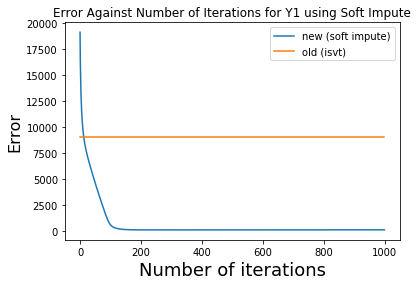

124.99304013377694


In [28]:
params=np.array([0.999999**i for i in range(1000)])
err=[np.linalg.norm(Xtrue-Z,'fro')**2 for Z in SoftImpute(Y1,params,2)]
iterations=np.array([i for i in range(len(err))])
plt.title('Error Against Number of Iterations for Y1 using Soft Impute')
plt.xlabel('Number of iterations', fontsize=18)
plt.ylabel('Error', fontsize=16)
plt.plot(iterations,err,label='new (soft impute)')
plt.plot(iterations,[isvt_e1]*len(err),label='old (isvt)')
plt.legend()
plt.show()
print(err[-1])

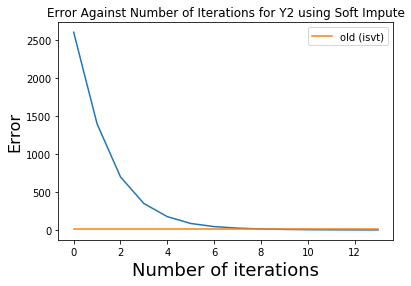

1.517781516959495


In [29]:
params=np.array([50,25,12,6,3,1,0.5,0.25,0.1,0.01,0.001,0.0001,0.00001,0.000001])
err=[np.linalg.norm(Xtrue-Z,'fro')**2 for Z in SoftImpute(Y2,params,2)]
iterations=np.array([i for i in range(len(err))])
plt.title('Error Against Number of Iterations for Y2 using Soft Impute')
plt.xlabel('Number of iterations', fontsize=18)
plt.ylabel('Error', fontsize=16)
plt.plot(iterations,err)
plt.plot(iterations,[isvt_e2]*len(err),label='old (isvt)')
plt.legend()
plt.show()
print(err[-1])

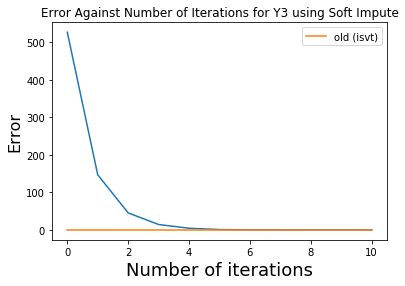

0.0009133068399137951


In [30]:
params=np.array([50,25,12,6,3,1,0.5,0.25,0.1,0.01,0.001])
err=[np.linalg.norm(Xtrue-Z,'fro')**2 for Z in SoftImpute(Y3,params,2)]
iterations=np.array([i for i in range(len(err))])
plt.title('Error Against Number of Iterations for Y3 using Soft Impute')
plt.xlabel('Number of iterations', fontsize=18)
plt.ylabel('Error', fontsize=16)
plt.plot(iterations,err)
plt.plot(iterations,[isvt_e3]*len(err),label='old (isvt)')
plt.legend()
plt.show()
print(err[-1])

In [13]:
def RandSVD(B,k,p,q):
    A=B.copy()
    m,n=A.shape
    A[np.isnan(A)]=0
    O=np.random.normal(size=(n,k+p))
    Y=np.linalg.matrix_power(A@A.T,q)@A@O
    V,R=np.linalg.qr(Y)
    B=(V.T)@A
    Phat,s,QT=np.linalg.svd(B)
    Q=QT.T
    S=np.diag(s)[:k,:k]
    P=V@Phat[:,:k]
    _,cols=S.shape
    return P@S@Q[:,:k].T

In [32]:
from itertools import product
pqproduct=product([0,0,1,1,2,2,5,5,10,10,50,50],repeat=2)
allpqs=[list(x) for x in pqproduct]
allresults=[np.linalg.norm(Xtrue-RandSVD(Y1,2,p,q),'fro') for p,q in allpqs]
print(f'old (isvt): {isvt_e1}\nnew (random svd) {min(allresults)}')

old (isvt): 8999.0
new (random svd) 168.9695657082258


In [15]:
minidx=np.argmin(allresults)
print(allpqs[minidx])

[0, 50]
